In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import pytorch_lightning as pl
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModel
%load_ext tensorboard
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
class GetFullDF:
    def __init__(self):
        self.df = None
    def __call__(self):
        if self.df is None:
            df = pd.concat([
        #         pd.read_csv(os.path.join('results_dir', 'results.csv')),
        #         pd.read_csv(os.path.join('results_dir2', 'results.csv')),
        #         pd.read_csv(os.path.join('results_dir3', 'results.csv')),
        #         pd.read_csv(os.path.join('results_dir4', 'results.csv')),
        #         pd.read_csv(os.path.join('results_32test/results_gpt2finetuned', 'results.csv')),
        #         pd.read_csv(os.path.join('results_32test//results_gpt2', 'results.csv')),
        #         pd.read_csv(os.path.join('results_32test/results_gptj', 'results.csv')),
                pd.read_csv(os.path.join('results/results_gpt2', 'results.csv')),
                pd.read_csv(os.path.join('results/results_gpt2orig', 'results.csv')),
                pd.read_csv(os.path.join('results/results_gpt2orig_2', 'results.csv')),
                pd.read_csv(os.path.join('results/results_gpt2orig_3', 'results.csv')),
        #         pd.read_csv(os.path.join('results/results_gpt2orig_4', 'results.csv')),
            ])
            df = df.drop_duplicates(['task', 'train_indices', 'checkpoint'])
            df = df.reset_index()
            df['sampling'] = 'within_task_random'
            df['method'] = 'in_context'
            df['descriptor'] = df[['checkpoint', 'sampling', 'method']].apply(tuple, axis=1)
            self.df = df
        return self.df
get_full_df = GetFullDF()
def evaluate_prediction_dfs(train_df, val_df):
    print('train corr: %f, val corr: %f' % (
        train_df.regression_predictions.corr(train_df.result),
        val_df.regression_predictions.corr(val_df.result)))
    chart = sns.scatterplot(data=train_df, x='result', y='regression_predictions', hue='task')
    plt.show()
    chart = sns.scatterplot(data=val_df, x='result', y='regression_predictions', hue='task')
    plt.show()

# Data

In [2]:
def get_breakdown(df):
    ckpts = sorted(list(set(df.checkpoint)))
    tasks = sorted(list(set(df.task)))
    samplings = sorted(list(set(df.sampling)))
    methods = sorted(list(set(df.method)))
    breakdown_df = pd.DataFrame({
        task: {
            (ch, sampling, method): len(df[(df.task == task) & (df.checkpoint == ch) & (df.sampling == sampling) & (df.method == method)])
            for ch in ckpts for sampling in samplings for method in methods
        } for task in tasks}).transpose()
    print(len(breakdown_df))
    return breakdown_df
get_breakdown(get_full_df())

4


,checkpoints/metaicl/hr_to_lr/model.pt,gpt2-large
,within_task_random,within_task_random
,in_context,in_context
biomrc,0,93
commonsense_qa,1000,1000
piqa,0,962
qasc,225,223


In [3]:
def get_prompt(train_samples):
    train_samples = eval(train_samples)
    return '\n\n'.join(['input: %s\noutput: %s\n' % (dp['input'], dp['output']) for dp in train_samples])
class PromptPerformanceDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        row = self.df.iloc[index]
        return dict(
            prompt=get_prompt(row.train_samples),
            label=row.result,
        )
class PromptsPerformanceData(pl.LightningDataModule):
    def __init__(self, get_df_func, **dataloader_kwargs):
        super().__init__()
        self.get_df_func = get_df_func
        self.dataloader_kwargs = dataloader_kwargs
        self._train, self._val, self._test = None, None, None
    def setup(self, stage=None):
        train_percent, val_percent, seed = .8, .1, 0
        df = self.get_df_func()
        df[df.k != 0]
        length = len(df)
        train_length = int(length * train_percent)
        val_length = int(length * val_percent)
        lengths = [train_length, val_length, length - train_length - val_length]
        rows = [r for i, r in df.iterrows()]
        splits = random_split(rows, lengths, generator=torch.Generator().manual_seed(seed))
        self._train, self._val, self._test = [
            PromptPerformanceDataset(pd.DataFrame(list(x))) for x in splits]
    def train_dataloader(self):
        return DataLoader(self._train, **self.dataloader_kwargs, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self._val, **self.dataloader_kwargs)
    def test_dataloader(self):
        return DataLoader(self._test, **self.dataloader_kwargs)

# Linear Regression on per-example Binary Variables

In [4]:
def get_features(indices):
    x = np.zeros(200)
    x[np.array(indices)] = 1
    return x
def getxy(df):
    X = np.stack(df.apply(lambda r: get_features(eval(r.train_indices)), axis=1))
    y = np.array(df.result)
    return X, y
def setup_and_train_linear_regression(task, checkpoint):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df)
    dm.setup()
    X_train, y_train = getxy(dm._train.df)
    print('train shapes: X - %s, y - %s' % (str(X_train.shape), str(y_train.shape)))
    X_val, y_val = getxy(dm._val.df)
    print('val shapes: X - %s, y - %s' % (str(X_val.shape), str(y_val.shape)))
    model = LinearRegression()
    model.fit(X_train, y_train)
    return dm, model
def get_prediction_dfs_linear_regression(dm, model):
    X_train, y_train = getxy(dm._train.df)
    y_train_pred = model.predict(X_train)
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = y_train_pred
    X_val, y_val = getxy(dm._val.df)
    y_val_pred = model.predict(X_val)
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = y_val_pred
    print('train regression score: %s, val regression score: %s' % (model.score(X_train, y_train), model.score(X_val, y_val)))
    return train_df, val_df

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)
train regression score: 0.4686504915277756, val regression score: -0.01753806716938411
train corr: 0.684595, val corr: 0.370681


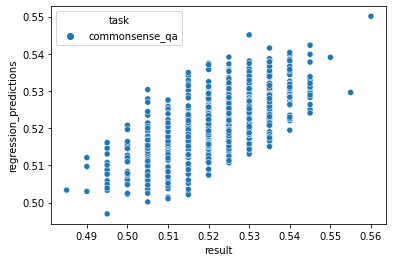

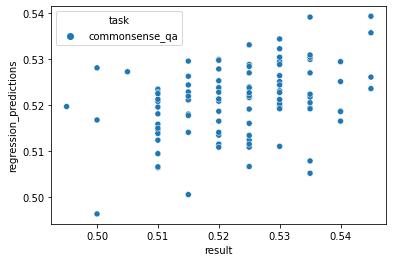

In [5]:
dm, model = setup_and_train_linear_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt')
train_df, val_df = get_prediction_dfs_linear_regression(dm, model)
evaluate_prediction_dfs(train_df, val_df)

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)
train regression score: 0.5907339723109073, val regression score: 0.23087515045507434
train corr: 0.768593, val corr: 0.545666


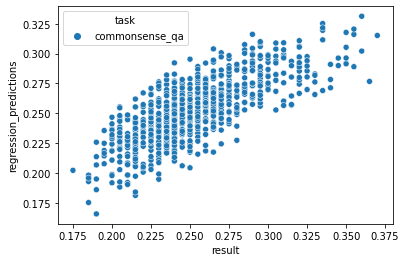

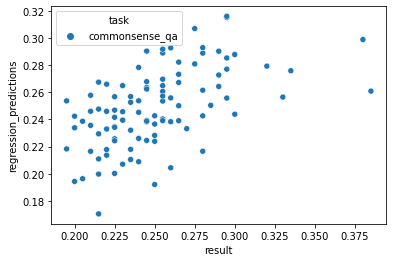

In [6]:
dm, model = setup_and_train_linear_regression('commonsense_qa', 'gpt2-large')
train_df, val_df = get_prediction_dfs_linear_regression(dm, model)
evaluate_prediction_dfs(train_df, val_df)

train shapes: X - (769, 200), y - (769,)
val shapes: X - (96, 200), y - (96,)
train regression score: 0.4987587898354934, val regression score: -0.0810967668419913
train corr: 0.706295, val corr: 0.263506


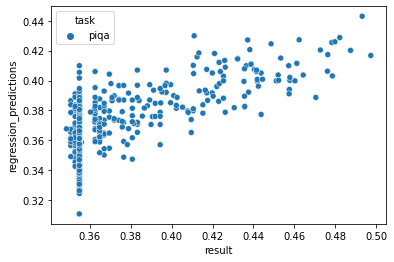

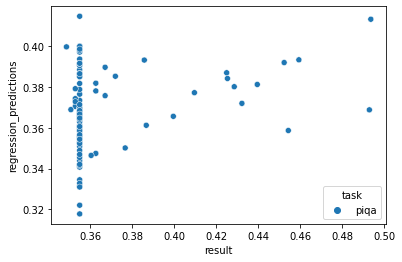

In [7]:
dm, model = setup_and_train_linear_regression('piqa', 'gpt2-large')
train_df, val_df = get_prediction_dfs_linear_regression(dm, model)
evaluate_prediction_dfs(train_df, val_df)

# Bert Regression

### Model

In [8]:
class StringRegressionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = AutoModel.from_pretrained('roberta-base')
        self.linear = nn.Linear(768, 1)
        self.loss = nn.MSELoss()
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-4)
    def forward(self, batch):
        out = self.model(**batch['text'])
        predictions = self.linear(out[1]).squeeze(-1)
        return predictions
    def shared_step(self, batch, step_type):
        predictions = self(batch)
        loss = self.loss(predictions, batch['label'])
        self.log('loss/%s' % step_type, loss.item())
        return loss
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, 'test')
    def predict_step(self, batch, batch_idx):
        return self(batch).cpu().numpy()
class CollateFn:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    def __call__(self, instances):
        return dict(
            text=self.tokenizer([self.tokenizer.cls_token + ' ' + i['prompt'] for i in instances], return_tensors='pt', padding=True, truncation=True),
            label=torch.tensor([i['label'] for i in instances], dtype=torch.float32)
        )
def setup_and_train_roberta_regression(task, checkpoint):
    def get_df():
        df = get_full_df()
        return df[(df.task == task) & (df.checkpoint == checkpoint)]
    dm = PromptsPerformanceData(get_df, batch_size=32, collate_fn=CollateFn())
    dm.setup()
    model = StringRegressionModel()
    trainer = pl.Trainer(gpus=1, max_epochs=3, log_every_n_steps=10)
    trainer.fit(model, datamodule=dm)
    return trainer, dm, model
def get_prediction_dfs_roberta_regression(trainer, dm, model):
    train_reg_preds = np.concatenate(trainer.predict(model, dm.train_dataloader()))
    train_df = dm._train.df.copy()
    train_df['regression_predictions'] = train_reg_preds
    val_reg_preds = np.concatenate(trainer.predict(model, dm.val_dataloader()))
    val_df = dm._val.df.copy()
    val_df['regression_predictions'] = val_reg_preds
    return train_df, val_df

### Training and evaluating the model

In [9]:
%tensorboard --logdir=lightning_logs --port 6060

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /scratch/mcinerney.de/metaicl/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
------

Sanity Checking: 0it [00:00, ?it/s]

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 25it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 25it [00:00, ?it/s]

train corr: -0.001228, val corr: 0.064693


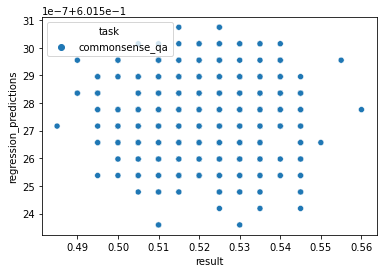

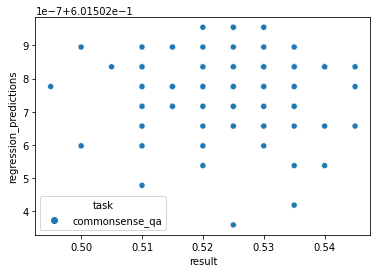

In [10]:
trainer, dm, model = setup_and_train_roberta_regression('commonsense_qa', 'checkpoints/metaicl/hr_to_lr/model.pt')
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
----------------------------------------
0 | model  | RobertaModel | 124 M

Sanity Checking: 0it [00:00, ?it/s]

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 25it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 25it [00:00, ?it/s]

train corr: -0.040644, val corr: -0.117639


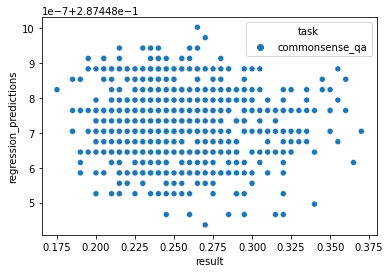

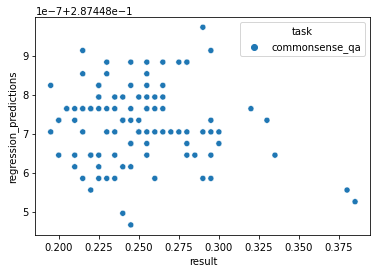

In [11]:
trainer, dm, model = setup_and_train_roberta_regression('commonsense_qa', 'gpt2-large')
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
----------------------------------------
0 | model  | RobertaModel | 124 M

Sanity Checking: 0it [00:00, ?it/s]

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 25it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 25it [00:00, ?it/s]

train corr: 0.014630, val corr: 0.153685


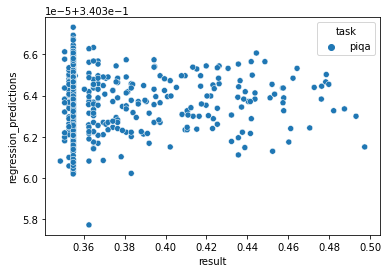

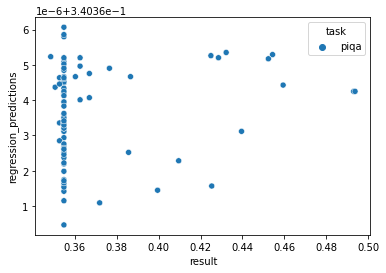

In [12]:
trainer, dm, model = setup_and_train_roberta_regression('piqa', 'gpt2-large')
train_df, val_df = get_prediction_dfs_roberta_regression(trainer, dm, model)
evaluate_prediction_dfs(train_df, val_df)

# Per-example Correlation Coefficient Regression

For a given example, can we estimate how the correlation coefficient between including the example in the prompt and the score? If so, we would be able to estimate which examples are more positively correlated and use them in the prompt.

In [40]:
dm, model = setup_and_train_linear_regression('commonsense_qa', 'gpt2-large')
print(model.coef_)

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)
[-1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10 -1.95857148e+10
 -1.958571

Small aside: even though the coefficients are quite large and not very different from one another, it is their differences that matter. You can see that if you set all coefficients to the mean of the coefficients, the regression fails:

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)
train regression score: -8.696865950486021e-05, val regression score: -0.0015344755462025628
train corr: 0.076014, val corr: -0.006981


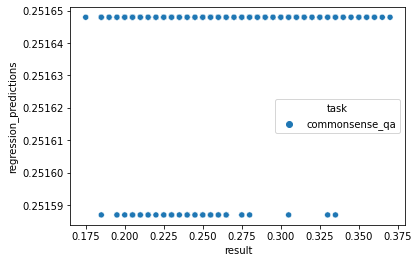

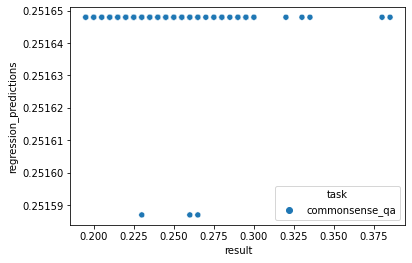

In [41]:
dm, model = setup_and_train_linear_regression('commonsense_qa', 'gpt2-large')
model.coef_[:] = model.coef_.mean()
train_df, val_df = get_prediction_dfs_linear_regression(dm, model)
evaluate_prediction_dfs(train_df, val_df)

train shapes: X - (800, 200), y - (800,)
val shapes: X - (100, 200), y - (100,)


,task,input,output,options,coefficient
98,commonsense_qa,Where can you watch information on lizards?,documentary,"[on the back of a cereal box., costa rica, gar...",-19585714803.030926
194,commonsense_qa,"Dogs run around all day, it's a good thing the...",four legs,"[pointed ears, fleas, bones, tails, four legs]",-19585714803.01585
107,commonsense_qa,Where are seats most likely bleachers?,hockey game,"[movies, opera, theater, lecture hall, hockey ...",-19585714803.018524
10,commonsense_qa,What is someone likely to experience when havi...,enjoyment,"[enjoyment, euphoria, excitement, crying, laug...",-19585714803.020073
66,commonsense_qa,"The children were making each other laugh, the...",tickle,"[play ball, reading a book, jump rope, tickle,...",-19585714803.028954
...,...,...,...,...,...
90,commonsense_qa,"Joe is looking for his comb, which he keeps ne...",medicine cabinet,"[bedstand, medicine cabinet, suitcase, barber ...",-19585714803.020012
80,commonsense_qa,"His cupboards were barren, so he had to go to ...",eat,"[earn money, eat, take bus, make money, sleep]",-19585714803.040386
142,commonsense_qa,"The saw was not necessary for car repair, so w...",tool kit,"[tool shed, tool box, tool kit, hardware store...",-19585714803.03606
183,commonsense_qa,Diligently taking care of proposals got him go...,results,"[paper work, getting work done, marriage, resu...",-19585714803.029785


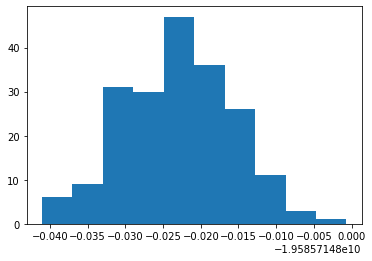

In [42]:
dm, model = setup_and_train_linear_regression('commonsense_qa', 'gpt2-large')
plt.hist(model.coef_)
df = get_full_df()
df = df[(df.task == 'commonsense_qa') & (df.checkpoint == 'gpt2-large')]
examples_df = {}
for i, row in df.iterrows():
    for index, example in zip(eval(row.train_indices), eval(row.train_samples)):
        example['coefficient'] = model.coef_[index]
        examples_df[index] = example
examples_df = pd.DataFrame(examples_df).transpose()
examples_df

### Data